# Descripción
Primera versión del modelo de estimación de fechas de aprobacion sin mucha limpieza de datos

In [1]:
import numpy as np
import pandas as pd
import missingno as msn
import matplotlib.pyplot as plt
import os
import seaborn as sns


In [2]:
#Direccion del documento
#path=os.path.dirname(os.path.realpath('Ordenes%20de%20compra%20PORTAL%201K%20(datos%20completo).xlsx'))
#path

In [3]:
#Subir la dirección local de donde tengan los datos
df=pd.read_excel('C:\\Users\\Admin\\OneDrive\\Documentos\\DataScience2021-2\\Trabajos_propios_felipe\\Proyecto_final\\Ordenes de compra PORTAL 1K (datos completo).xlsx')

In [4]:
#Manejo inicial de base de datos
df.drop(labels=['Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28'],axis=1,inplace=True)
df.drop_duplicates(inplace=True)

#Cambiando formato de variables
df['FECHA ORDEN']=pd.to_datetime(df['FECHA ORDEN'],format='%Y-%m-%d',errors = 'coerce')
df['FECHA ENTREGA']=pd.to_datetime(df['FECHA ENTREGA'],format='%Y-%m-%d',errors = 'coerce')
df['FECHA APROBACION']=pd.to_datetime(df['FECHA APROBACION'],format='%Y-%m-%d',errors = 'coerce')
df['FECHA ULTIMO MOVIMIENTO']=pd.to_datetime(df['FECHA ULTIMO MOVIMIENTO'],format='%Y-%m-%d',errors = 'coerce')
df['PRECIO UNITARIO']=df['PRECIO UNITARIO'].apply(lambda x:float(x.replace('.','')))
df['PRECIO UNITARIO + IVA']=df['PRECIO UNITARIO + IVA'].apply(lambda x:float(x.replace('.','')))
df['IVA']=df['IVA'].apply(lambda x:float(x.replace('.','')))
df['TOTAL SIN IVA']=df['TOTAL SIN IVA'].apply(lambda x:float(x.replace('.','')))
df['TOTAL + IVA']=df['TOTAL + IVA'].apply(lambda x:float(x.replace('.','')))

#Eliminamos columnas que no usaremos
df.drop(labels=['CANTIDAD RECIBIDA','CENTRO DE COSTOS','PRESUPUESTO'],inplace=True,axis=1)



In [10]:
#Creacion de nuevos features

#Con las fechas de aprobacion
df['dia fecha aprobacion']=df['FECHA APROBACION'].dt.dayofweek #0 lunes, 6 domingo
df['mes fecha aprobacion']=df['FECHA APROBACION'].dt.month #Meses de aprobación 
df['semana del año aprobacion']=df['FECHA APROBACION'].dt.isocalendar().week

#Con las fechas de orden
df['dia fecha orden']=df['FECHA ORDEN'].dt.dayofweek #0 lunes, 6 domingo
df['mes fecha orden']=df['FECHA ORDEN'].dt.month #Meses de ordbación 
df['semana del año orden']=df['FECHA ORDEN'].dt.isocalendar().week

#Variable objetivo
df['dias para aprobación']=df['FECHA APROBACION']-df['FECHA ORDEN']
df['dias para aprobación']=(df['FECHA APROBACION']-df['FECHA ORDEN']).dt.days

# MODELO

In [6]:
from pycaret.regression import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import random

### Variables usadas para entrenar el modelo inicial:
- Dia fecha aprobacion = Dia de la semana que se aprobo la orden
- Dia fecha orden = Dia de la semana que se hizo la orden
- Mes fecha orden = Mes del año que se realizo la orden
- semana del año orden = Semana del año que se hizo la orden
- Usuario aprobador = Usuario que aprueba la orden  
### Variable objetivo
- dias para aprobación = Fecha aprobacion - fecha orden 

In [11]:
variables=df[['dia fecha aprobacion', 'dia fecha orden',
       'mes fecha orden', 'semana del año orden','dias para aprobación','USUARIO APROBADOR']]

In [12]:
#Manipulación de datos faltantes
variables['dias para aprobación']=np.where(variables['dias para aprobación'].isnull()==True,variables['dias para aprobación'].mode(),
                                          variables['dias para aprobación'])

"""Esto es solo una aproximación, creo que se puede mejorar bastante"""

'Esto es solo una aproximación, creo que se puede mejorar bastante'

In [20]:
#Acomodando los datos para entrarlos al modelo
variables['semana del año orden']=variables['semana del año orden'].astype('float64')
variables['dias para aprobación']=variables['dias para aprobación'].astype('int64')

In [24]:
#Datos de entrenamiento y prueba
random.seed(21)
train,test=train_test_split(variables,train_size=0.7)
print(train.shape)
print(test.shape)

(15674, 6)
(6718, 6)


In [25]:
setup(train,target='dias para aprobación',
            train_size=0.7,
            preprocess=True,
            remove_multicollinearity=True,
             multicollinearity_threshold=0.8,
            numeric_features=['dia fecha aprobacion','dia fecha orden',
                           'mes fecha orden','semana del año orden'],
      remove_outliers=True
      
            );

,Description,Value
0,session_id,2852
1,Target,dias para aprobación
2,Original Data,"(15674, 6)"
3,Missing Values,True
4,Numeric Features,4
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(10422, 23)"


In [26]:
compare_models(fold=10,sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,0.2603,88.2399,5.6472,0.9187,0.1654,0.0326,0.0070
et,Extra Trees Regressor,0.2894,85.8912,6.0301,0.9186,0.1491,0.0254,0.1520
rf,Random Forest Regressor,0.4388,110.1288,7.8273,0.8909,0.2256,0.0358,0.1550
gbr,Gradient Boosting Regressor,1.4402,128.7786,9.4133,0.8647,0.4863,0.3503,0.0720
knn,K Neighbors Regressor,0.5553,153.7827,9.7511,0.8438,0.2540,0.0742,0.0150
lightgbm,Light Gradient Boosting Machine,1.0260,159.8252,11.4466,0.8216,0.4088,0.1905,0.0560
ada,AdaBoost Regressor,5.1467,221.7832,14.1166,0.7345,0.8604,1.1506,0.0420
br,Bayesian Ridge,6.7425,350.3638,18.1743,0.5804,0.9667,1.7855,0.0070
ridge,Ridge Regression,6.7456,350.3338,18.1751,0.5804,0.9669,1.7880,0.0050
lar,Least Angle Regression,6.7523,350.3567,18.1789,0.5802,0.9675,1.7933,0.0060


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=2852, splitter='best')

In [27]:
#Elección de modelo
final_model=create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1493,20.8116,4.5620,0.9763,0.1347,0.0052
1,0.2813,41.2357,6.4215,0.9367,0.2163,0.0112
2,0.0787,3.8332,1.9579,0.9932,0.1438,0.0181
3,0.0519,1.5944,1.2627,0.9977,0.0758,0.0041
4,0.0809,1.9850,1.4089,0.9965,0.1410,0.0160
5,0.0186,0.0815,0.2855,0.9999,0.0715,0.0078
6,0.1855,29.6313,5.4435,0.9647,0.1196,0.0075
7,0.0744,4.4675,2.1136,0.9932,0.1347,0.0068
8,1.4415,605.4678,24.6063,0.4757,0.2615,0.0232
9,0.5326,149.8036,12.2394,0.8519,0.1920,0.1544


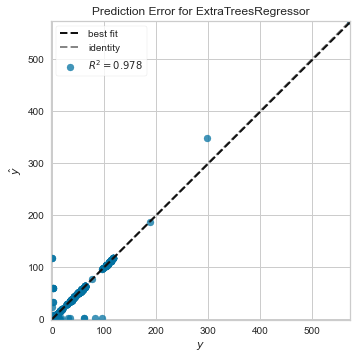

In [28]:
plot_model(final_model,plot='error')

In [29]:
predicciones=predict_model(final_model,data=test,round=2)
predicciones[['dias para aprobación','Label']]

,dias para aprobación,Label
8600,2,2.00
18593,64,64.00
17664,56,56.00
7484,0,0.00
18348,58,58.00
...,...,...
20194,0,0.00
3474,0,0.00
386,1,0.99
2968,0,0.00


In [ ]:
interpret_model(final_model)